# Creating Lysozym dataset as foreseen for JF Detector


## from Dectris/Eiger 4M data to Jungfrau Format 

remove Eiger inter modules pixels :
- 10 pixels H
- 37 pixels V

remove inter chip pixel 
- 2 pixels  H & V


## creation of pedestal, gain matrix correction

- removing extra pixel

inter chip

inter module

- adding (random) pedestal / gain

G0 G1 G2 for raw data MSB : 01 11 11

P0 0  0


## Bragg peak Detection

remove bad pixel

counting spots



In [1]:
import os,numba
import numpy as np
os.environ["HDF5_PLUGIN_PATH"]='/users/ponsard/.local/lib/python3.5/site-packages/hdf5plugin/manylinux/x86_64/'
import h5py
import matplotlib
matplotlib.use('Qt5Agg')
import matplotlib.pyplot as plt

%matplotlib notebook

In [2]:
savedir='/segfs/deg/working/ponsard/Detector/paper1/'

In [3]:


#data from dectris
f = h5py.File('/scratch/ponsard/Lysozym/lys1_7_data_000002.h5', 'r')
eiger_data = f.get('entry').get('data').get('data')


In [4]:
eiger_data.shape,eiger_data.dtype

((1000, 2167, 2070), dtype('uint16'))

<IPython.core.display.Javascript object>


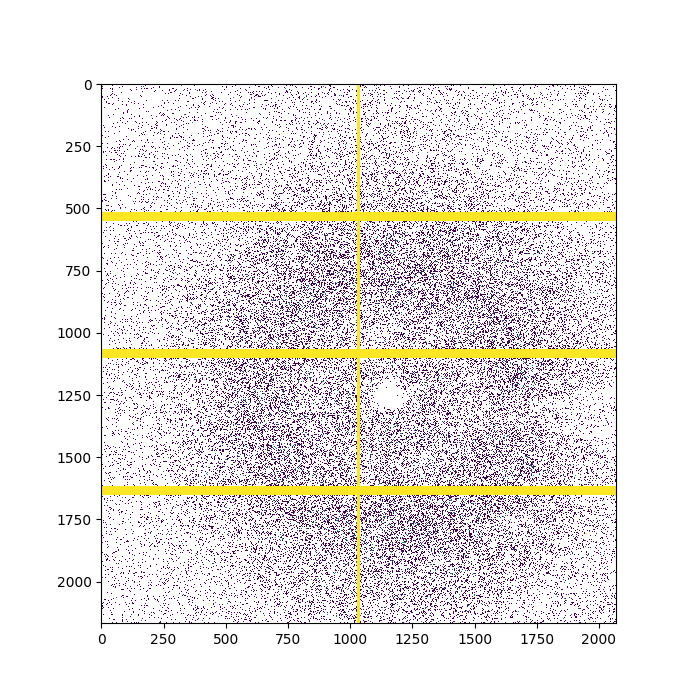

dtype('uint16')

In [5]:
from matplotlib.colors import LogNorm

fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(7,7))
ax.imshow(eiger_data[11],norm=LogNorm(vmin=1, vmax=10))
eiger_data.dtype

In [6]:
# create a 4k whole image without border
def creat_ds(n):
    x0=[0,   258, 516, 774,  1040, 1298, 1556, 1814]
    x1=[256, 514, 772, 1030, 1296, 1554, 1812, 2070]
    y0=[0,   258, 551, 809,  1102, 1360, 1653, 1911]
    y1=[256, 514, 807, 1065, 1358, 1616, 1909, 2167]
    #full image
    ds_jf = np.zeros((n,2048,2048),dtype=np.uint16)
    for i in range(n):
        if i%100==0:
            print(i)
        for x in range(8):
            _x0=x0[x]
            _x1=x1[x]
            for y in range(8):
                _y0=y0[y]
                _y1=y1[y]
                ds_jf[i, y*256:(y+1)*256, x*256:(x+1)*256]  = eiger_data[i,_y0:_y1,_x0:_x1]
    return ds_jf

ds_4k_100 = creat_ds(100)


0


<IPython.core.display.Javascript object>


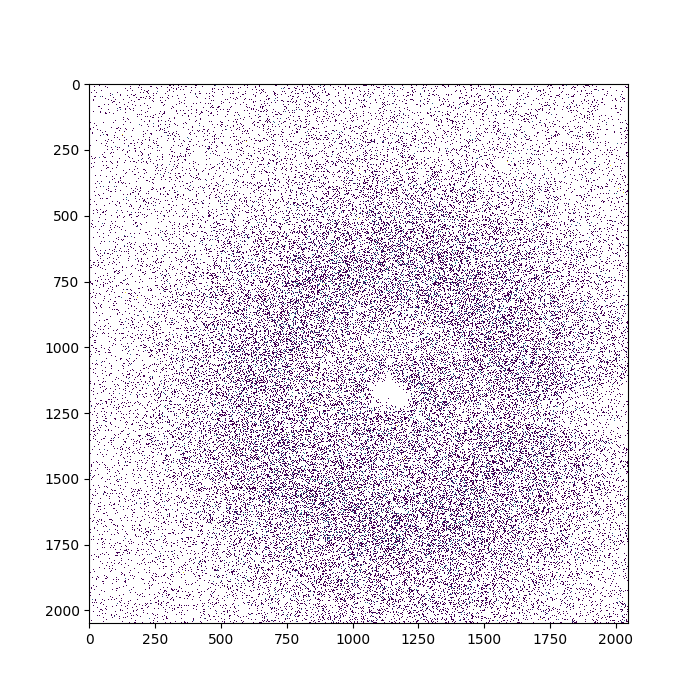

In [8]:
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(7,7))
ax.imshow(ds_4k_100[21],norm=LogNorm(vmin=1, vmax=10))

In [ ]:
#one single 1024x512 module
# rx=1 #0 1
# ry=1 #0 1 2 3
#single module


@numba.jit(nopython=True)
def create_ds_mjf(data,nImg,rx,ry):
    mjf= np.zeros((nImg,512,1024), dtype=np.float32)
    x0=[0,   258, 516, 774,  1040, 1298, 1556, 1814]
    x1=[256, 514, 772, 1030, 1296, 1554, 1812, 2070]

    y0=[0,   258, 551, 809,  1102, 1360, 1653, 1911]
    y1=[256, 514, 807, 1065, 1358, 1616, 1909, 2167]
    for n in range(nImg):
#         if n%100==0:
#             print(rx,ry,'n=',n)
        for x in range(4):
            _x0=x0[4*rx+x]
            _x1=x1[4*rx+x]
            for y in range(2):
                _y0=y0[2*ry+y]
                _y1=y1[2*ry+y]
                mjf[n, y*256:(y+1)*256, x*256:(x+1)*256]  = data[n,_y0:_y1,_x0:_x1]
    return mjf





NIMG = 1000
data=np.asarray(eiger_data)
ds1000 = create_ds_mjf(data,NIMG,1,0)


In [ ]:
# ds1000.shape
ds_4k_100.shape

In [ ]:
ds_4k.tofile(savedir+'lz_4M_1000.data')

## Compute Bragg spots using Numpy

In [9]:
def compute_spots(ds):
    res=[]
    nImg = ds.shape[0]
    for n in range (nImg):
#         if n%100==0:
#                 print('n=',n)
        img = np.copy(ds[n])
        img[img<1]=0
        img[img>6]=0
        res.append(len(img.nonzero()[0]))
    return res

<IPython.core.display.Javascript object>


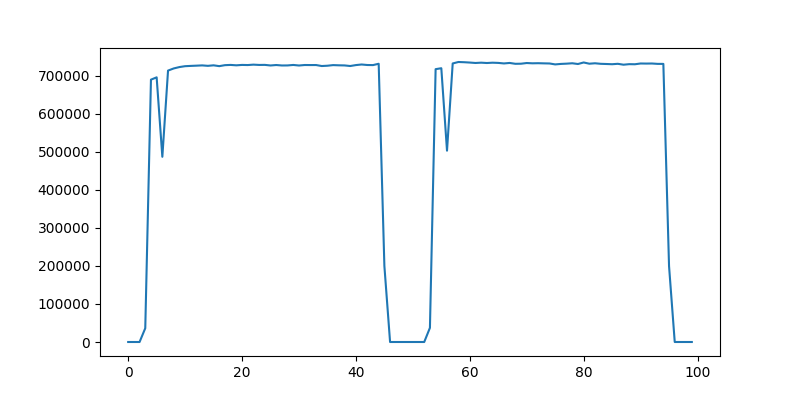

In [10]:
spots1=compute_spots(ds_4k_100)

fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(8,4))
ax.plot(spots1)


## add pedestal & gain


In [11]:
n,jf_mh,jf_mw = 1000,512,1024
n,jf_mh,jf_mw = 1000,2048,2048


gmask=[0,                  #not used
       0b0100000000000000, #G0
       0b1000000000000000, #G1
       0b1100000000000000] #G2
g = np.fromfile('/tmp/gain4M.data',dtype=np.float32)

# g = np.random.random(4*jf_mh*jf_mw)
# g = (g.reshape((4,jf_mh,jf_mw))).astype(dtype=np.float32)
# g[1]=(g[1])+2.0
# g[2]=(g[2])+2.0
# g[3]=(g[3])+2.0
# g[0]=0
# g.tofile('/tmp/gain4M.data')
# g.tofile(savedir+'gain4M.data')


gain = g.reshape((4,jf_mh,jf_mw))



In [12]:
import numba

@numba.jit(nopython=True)
def createDsWithInterPedestal2(ds):
    gmask=[0,                  #not used
       0b0100000000000000, #G0
       0b1000000000000000, #G1
       0b1100000000000000] #G2
    nImg,jf_mh,jf_mw = ds.shape
    jfimg = np.copy(ds)
    jf_raw_pe = np.zeros((2*nImg,ds.shape[1],ds.shape[2]),dtype=np.uint16)

    #suppress invalid pixel CHECKME
#     jfimg[jfimg>6]=0
    
#   #create pseudo pedestal
    p = np.random.random(nImg*jf_mh*jf_mw)
    p = p.astype(np.uint16)
    p = p.reshape((nImg,jf_mh,jf_mw))
    p = (4*p)
    pedestal         = np.zeros((4,nImg,jf_mh,jf_mw),dtype=np.uint16)
    pedestal[1]      = p #pedestal non null only for first gain G0
    
    for i in range (nImg):
        for x in range(ds.shape[1]):
            for y in range(ds.shape[2]):
#               #compute JF raw data with random gain (same r per image)
                r = np.random.randint(3)+1 #gain in [1,2,3]
                a = np.uint16(jfimg[i][x][y]*gain[r][x][y]+pedestal[r][i][x][y])
                if a > 0b0011111111111111: 
                    print('overflow',jfimg[i][x][y],gain[r][x][y],pedestal[r][i][x][y])
#                
                jf_raw_pe[2*i][x][y] = np.uint16(a) | gmask[np.uint16(r)] 
                
#                 #add pedestal intermediate image
                jf_raw_pe[2*i+1][x][y] = pedestal[r][i][x][y]
        
    return jf_raw_pe




In [33]:
ds=ds_4k_100

ds[ds>6]=0
ds_p_g   = createDsWithInterPedestal2(ds)
ds_p_g.shape


(200, 2048, 2048)

In [34]:
width,height,nImg,bdepth = 2048,2*2048,100,2
ds_p_g.tofile('/tmp/lz_4M_100.data')#,dtype=np.uint16,count=width*height*nImg*bdepth)
ds_p_g.tofile(savedir+'lz_4M_100.data')#,dtype=np.uint16,count=width*height*nImg*bdepth)


In [ ]:
import sys
import numpy as np
sys.path.append('/users/ponsard/notebooks/csi')
from libdeep.trunk.python.libdeep import DeepDevice, DeepArray
remu = DeepDevice('localhost')
m='XXXX'
remu.command('REMU STOP')

remu.command('DATASRC CONFIG '+str(100)+' '+str(200)+' '+str(8*3)+'  0 0 0.0')
a = DeepArray(ds.tobytes())
        
cmd='REMU STOP'
print(cmd)
remu.command(cmd)
cmd='*DATASET '+m+' '+str(2048)+' '+str(4096)+' '+str(10)
print(cmd)
remu.command(cmd,a)
cmd='DATASRC ADD '+m+' '
print(cmd)
remu.command(cmd)

In [ ]:
# ds_p_g.tofile(savedir+'lz_500k_1000.data')
# ds_p_g.tofile('/tmp/lz_500k_1000.data')
# ds_p_g.tofile('/tmp/lz_4M_1000.data')
# ds_p_g.tofile(savedir+'lz_4M_1000.data')


In [ ]:
# def createDsWithInterPedestal(ds):
#     nImg = ds.shape[0]
#     jfimg = np.copy(ds)
#     jf_raw_pe = np.zeros((2*nImg,ds.shape[1],ds.shape[2]),dtype=np.uint16)

#     #suppress invalid pixel
#     jfimg[jfimg>6]=0
    
#     #create pseudo pedestal
#     p = np.random.random(nImg*jf_mh*jf_mw)
#     p = p.reshape((nImg,jf_mh,jf_mw))
#     p = (4*p).astype(dtype=np.uint16)
#     pedestal         = np.zeros((4,nImg,jf_mh,jf_mw),dtype=np.uint16)
#     pedestal[1]      = p #pedestal non null only for first gain G0
    
#     for i in range (nImg):
#         #compute JF raw data with random gain (same r per image)
#         r = np.random.randint(3)+1 #gain in [1,2,3]
#         a = jfimg[i]*gain[r]+pedestal[r][i]
#         if (a > 0b0011111111111111).any():
#             print('overflow')
#         jf_raw_pe[2*i] = (a.astype(dtype=np.uint16) | gmask[r])
#         #add pedestal intermediate image
#         jf_raw_pe[2*i+1] = pedestal[r][i]
        
#     return jf_raw_pe






In [ ]:
# ds1000_gain_ped = createDsWithInterPedestal(ds1000) 
# ds_tp_gp        = createDsWithInterPedestal(ds_teapot) 

In [18]:
# def _applyCorrection2(ds):
#     print(ds.shape)
#     nImg = int(ds.shape[0]/2)
#     rc = np.zeros((nImg,ds.shape[1],ds.shape[2]),dtype=np.uint16)
#     _applyCorrection2(ds,rc)

@numba.jit(nopython=True)
def applyCorrection2(ds):
    nImg = int(ds.shape[0]/2)
    rc = np.zeros((nImg,ds.shape[1],ds.shape[2]),dtype=np.uint16)
    for i in range(nImg):
        for x in range(ds.shape[1]):
            for y in range(ds.shape[2]):
                img   = ds[2*i][x][y]
                pedes = ds[2*i+1][x][y]

                r = img>>14
                if r==0:
                    print('gain factor error')
                res = ((img & 0b0011111111111111)-pedes) / gain[r][x][y] 
#                 if (res>6):
#                     print('max error',i,res)
 
                rc[i][x][y] = np.uint16(round(res))
    return rc

In [35]:
ds_p_g=np.fromfile('/tmp/lz_4M_100.data',dtype=np.uint16)
ds_p_g=ds_p_g.reshape(200,2048,2048)


In [36]:
ds_p_g.shape

(200, 2048, 2048)

In [37]:
cor  = applyCorrection2(ds_p_g)
# (ds_teapot==cor100tp).all(),(ds1000==cor1000).all()

In [38]:
cor.shape

(100, 2048, 2048)

In [ ]:
# def applyCorrection(ds):
#     nImg = int(ds.shape[0]/2)
#     rc = np.zeros((nImg,512,1024),dtype=np.float32)
#     for i in range(nImg):
#         img   = ds[2*i]
#         pedes = ds[2*i+1]

#         r = img[0][0]>>14
#         if r==0:
#             print('gain factor error')
#         res = ((img & 0b0011111111111111).astype(np.float32)-pedes) / gain[r] 
#         if (res.max()>6):
#             print('max error',i,res.max())
 
#         rc[i] = res.round().astype(np.int16)
#     return rc



In [ ]:
# cor100tp = applyCorrection(ds_tp_gp)
# cor1000   = applyCorrection(ds1000_gain_ped)
# cor100.max(),cor100.min(), ds100.max(), ds100.min(),cor100tp.max(),cor100tp.min(),ds_teapot.max(),ds_teapot.min()

In [ ]:
#difference are invalid pixels
len((ds[N]!=cor[N]).nonzero()[0]),len((ds[N]>6).nonzero()[0])
# len((ds_teapot!=cor100tp).nonzero()[0])

<IPython.core.display.Javascript object>


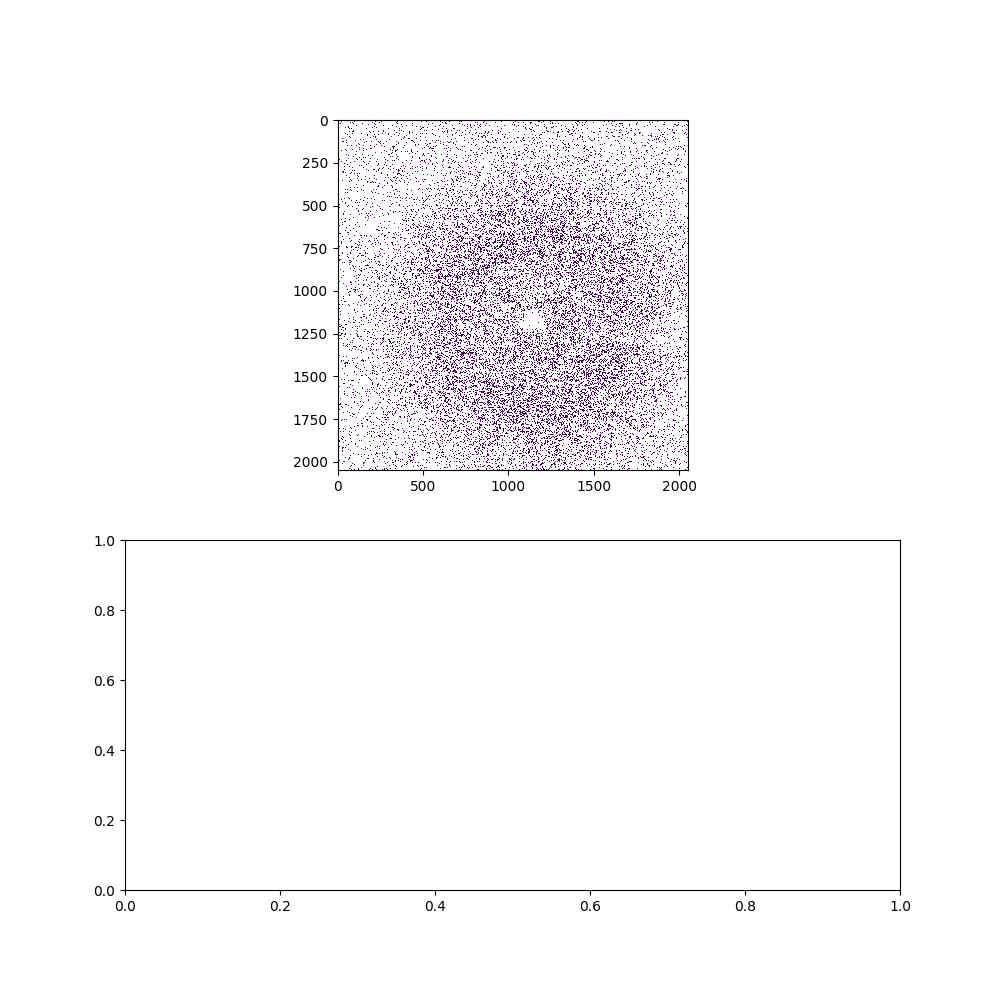

NameError: name 'ds_4k' is not defined

In [39]:
fig, ax = plt.subplots(nrows=2,ncols=1,figsize=(10,10))

N=31

# ax[0].imshow(cor1000[N],norm=LogNorm(vmin=1, vmax=100))
# ax[1].imshow(ds_teapot[N])#,norm=LogNorm(vmin=1, vmax=100))
ax[0].imshow(cor[N],norm=LogNorm(vmin=1, vmax=100))
ax[1].imshow(ds_4k[N],norm=LogNorm(vmin=1, vmax=100))




# Create Dataset in JF format (including Header and shuffle)

## 128x8246 images 

## 54 bytes header / 4 lines 1024 pixels

In [ ]:
def createDSwithJFHeader(im,bunchid=0,moduleid=0) :
    
    nImg,h,w=im.shape
    ds = np.zeros((nImg,128,8246),dtype=np.uint8)

    jf_header   = [0] * 54
    jf_header[0]= 0x11   #6 bytes padding used for test
    jf_header[1]= 0x22
    jf_header[2]= 0x33
    jf_header[3]= 0x44
    jf_header[4]= 0x55
    jf_header[5]= 0x66
    
    for N in range (nImg):
        uplines=downlines=lines = int(h/2)
        b = True;
        counter=0
        while lines > 0 :
            jf_header[6]  = N & 0xff                #framenum
            jf_header[7]  = (N>>8) & 0xff           #
            jf_header[18] = int((lines-1)/4)        #packetnum 0...127
            jf_header[22] = bunchid;                #bunchid
            jf_header[38] = moduleid;               #moduleid
            #print(jf_header[18])
            data = im[N][lines-4:lines] 
            ds[N][counter] = bytearray(jf_header) + data.tobytes()
            counter += 1
            if b:
                uplines += 4;
                lines = uplines;
            else:
                downlines -= 4;
                lines = downlines;
            b = not b;
    return ds



In [ ]:

ds1000_gain_ped_hdr = createDSwithJFHeader(ds_p_g)

In [ ]:
ds1000_gain_ped_hdr.tofile('/tmp')

In [ ]:



@numba.jit(nopython=True)
def compute(hdr1,hdr2,r_img,r_ped,img1,img2):
    rc    = np.zeros((512,1024),dtype=np.float32)

    for i in range(128):
        ii = hdr1[i,18]
        r_img[ii*4:(ii+1)*4] = img1[i].reshape(4,1024)
    
    for i in range(128):
        ii = hdr2[i,18]
        r_ped[ii*4:(ii+1)*4] = img2[i].reshape(4,1024)

    for x in range(512):
        for y in range(1024):
            r = r_img[x][y]>>14
            if r==0:
                print('error')
            rc[x][y] = round(((r_img[x][y] & 0b0011111111111111) - r_ped[x][y]) / gain[r][x][y])
    return rc
    
def fromdsWithHdrGainPedes2(ds,N):
    
    r_img = np.zeros((512,1024),dtype=np.uint16)
    r_ped = np.zeros((512,1024),dtype=np.uint16)

    raw1   = ds[2*N,:,54:8246]
    hdr1   = ds[2*N,:,0:54]
    
    img1 = np.frombuffer(raw1.tobytes(), dtype=np.uint16)
    img1 = img1.reshape(128,4096)
    
    raw2 = ds[2*N+1,:,54:8246]
    hdr2 = ds[2*N+1,:,0:54]

    img2 = np.frombuffer(raw2.tobytes(), dtype=np.uint16)
    img2 = img2.reshape(128,4096)
    
    #pedes = pedes.astype(np.float32)
    #put lines in place
    

    return compute(hdr1,hdr2,r_img,r_ped,img1,img2) 



In [ ]:
N=9
im  = fromdsWithHdrGainPedes2(ds1000_gain_ped_hdr,N)


In [ ]:


fig, ax = plt.subplots(nrows=2,ncols=1,figsize=(7,7))
ax[0].imshow(im,norm=LogNorm(vmin=1, vmax=100))
ax[1].imshow(ds[N],norm=LogNorm(vmin=1, vmax=100))

In [ ]:


def fromdsWithHdrGainPedes(ds,N):
    
    r_img = np.zeros((512,1024),dtype=np.uint16)
    r_ped = np.zeros((512,1024),dtype=np.uint16)
    rc    = np.zeros((512,1024),dtype=np.float32)

    raw1   = ds[2*N,:,54:8246]
    hdr1   = ds[2*N,:,0:54]
    
    img1 = np.frombuffer(raw1.tobytes(), dtype=np.uint16)
    img1 = img1.reshape(128,4096)
    
    raw2 = ds[2*N+1,:,54:8246]
    hdr2 = ds[2*N+1,:,0:54]

    img2 = np.frombuffer(raw2.tobytes(), dtype=np.uint16)
    img2 = img2.reshape(128,4096)
    
    #pedes = pedes.astype(np.float32)
    #put lines in place
    for i in range(128):
        ii = hdr1[i,18]
        r_img[ii*4:(ii+1)*4] = img1[i].reshape(4,1024)
    
    for i in range(128):
        ii = hdr2[i,18]
        r_ped[ii*4:(ii+1)*4] = img2[i].reshape(4,1024)

    for x in range(512):
        for y in range(1024):
            r = r_img[x][y]>>14
            if r==0:
                print('error')
            rc[x][y] = ((r_img[x][y] & 0b0011111111111111)-r_ped[x][y]) / gain[r][x][y] 

    return rc.round().astype(np.uint16) 
   


In [ ]:

ds_tp_gp_with_hdr             = createDSwithJFHeader(ds_tp_gp)
ds_1000_gain_ped_with_hdr     = createDSwithJFHeader(ds1000_gain_ped)




In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

N=7
img = fromdsWithHdrGainPedes2(ds_1000_gain_ped_with_hdr,N)
# tp  = fromdsWithHdrGainPedes(ds_tp_gp_with_hdr,N)

fig, ax = plt.subplots(nrows=2,ncols=1,figsize=(7,7))
ax[0].imshow(img,norm=LogNorm(vmin=1, vmax=100))
ax[1].imshow(tp)#,norm=LogNorm(vmin=1, vmax=100))

In [ ]:
ds_1000_gain_ped_with_hdr.shape[0],ds_100_gain_ped_with_hdr.shape[0]

In [ ]:
def recons(ds):
    rc = np.zeros((int(ds.shape[0]/2),512,1024),dtype=np.uint16)
    for i in range(int(ds.shape[0]/2)):
        img = fromdsWithHdrGainPedes(ds,i)
        rc[i]=img
    return rc

In [ ]:
def compute_spots2(ds):
    res=[]
    nImg = ds.shape[0]
    for n in range (nImg):
        if n%100==0:
                print('n=',n)
        img  = ds[n]
        img = np.ma.masked_where(img<1,img)
        img = np.ma.masked_where(img>6,img)
        res.append(len(img.nonzero()[0]))
    return res

In [ ]:

# re = recons(ds_1000_gain_ped_with_hdr)
re = recons(ds_1000_gain_ped_with_hdr)

spots=compute_spots2(re)
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(8,4))
ax.plot(spots)

# Teapot for test

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import RashpaFrontEnd as rp
import numpy as np



NTEAPOT = 100

width,height,nImg,bdepth = 1024,512,NTEAPOT,2
# width,height,nImg,bdepth = 2048,2048,1000,2
tp = rp.loadImage('Utah_teapot_simple_2.png',(width,height))



## create dataset, take some time...

In [ ]:
ds_teapot = rp.createDatasetWithTag(tp,width,height,nImg)
ds_teapot = ds_teapot.reshape(nImg,height,width)
print(ds_teapot.shape)
ds_teapot = ds_teapot / 50
ds_teapot = ds_teapot.astype(np.uint16)


In [ ]:
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(8,7))

N=45
ax.imshow(ds_teapot[N])#, aspect='equal')

In [ ]:
# ds_tp_p_g   = createDsWithInterPedestal2(ds_teapot)
# ds_tp_p_g_h = createDSwithJFHeader(ds_tp_p_g)
# ds_tp_p_g_h.tofile('/tmp/teapot1000asJF.data')


In [ ]:
ds_tp_p_g   = createDsWithInterPedestal2(ds_teapot)
# ds_tp_p_g.tofile('/tmp/tp1000_gp.data')

In [ ]:
ds_tp_p_g.tofile(savedir+'tp100_500k_gp.data')

In [ ]:
ds_tp_p_g.shape,ds_tp_p_g.dtype

In [ ]:
tst=np.fromfile('/tmp/tp100_500k_gp.data',dtype=np.uint16)
tst=tst.reshape((2*100,512,1024))
tst_c  = applyCorrection2(tst)



In [ ]:
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(8,7))
from matplotlib.colors import LogNorm


N=28
x = ((tst[N] & 0b0011111111111111)-tst[N+1])/gain[1]
ax.imshow(tst_c[N])

# Build all

In [ ]:
NIMG = 1000

eiger_npdata=np.asarray(eiger_data)

for x in [0, 1]:
    for y in [0, 1, 2, 3]:
        
        ds       = create_ds_mjf(eiger_npdata,NIMG,x,y)
        #remove bad pixel
        ds[ds>6]=0
        ds_p_g   = createDsWithInterPedestal2(ds)
        fname = '/tmp/m'+str(x)+str(y)+'_p_g.data'
        ds_p_g.tofile(fname)
        print(fname,'saved')
        
#         ds_p_g_h = createDSwithJFHeader(ds_p_g)
#         fname = '/tmp/m'+str(x)+str(y)+'_p_g_h.data'
#         ds_p_g_h.tofile(fname)
        print(fname,'saved')

In [ ]:
g4 = np.zeros(4*512*1024*8,dtype=np.float32)
g4 = g4.reshape((4,2048,2048))
for c in [0,1]:
    for r in [0,1,2,3]:
        #print(c,r)
        g4[1,r*512:(r+1)*512,c*1024:(c+1)*1024] = gain[1]
        g4[2,r*512:(r+1)*512,c*1024:(c+1)*1024] = gain[2]
        g4[3,r*512:(r+1)*512,c*1024:(c+1)*1024] = gain[3]


# g4.tofile('/tmp/g4.data')

In [ ]:
!ls -l /tmp/g4.data 

In [ ]:
16777216/2048/4096

Simple dataset

In [ ]:
nImg = 100

ds = np.ones((nImg,1024,512*2),dtype=np.uint16)
for i in range (nImg):
    ds[i] = 0+i*ds[i]


In [ ]:
ds[55]

In [ ]:
ds.tofile('/tmp/id.data')

In [ ]:
ds.shape

# PyFAI DATASET

In [ ]:
n,w,h=100,1024,512

ds=np.fromfile('/tmp/pyfaids.data',dtype=np.uint16)
ds=ds.reshape((n,h,w))


In [ ]:
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(7,7))
ax.imshow(ds[0])#,norm=LogNorm(vmin=1, vmax=10))

In [ ]:
ds2=createDsWithInterPedestal2(ds)

In [ ]:
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(7,7))
ax.imshow(ds2[0])#,norm=LogNorm(vmin=1, vmax=10))

# ds2.tofile('/tmp/pyfai_pedestal.data')

In [ ]:
ds3=applyCorrection2(ds2)

In [ ]:
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(7,7))
ax.imshow(ds3[0])#,norm=LogNorm(vmin=1, vmax=10))